## **Practical No: 4**

### **AIM:** Classify the Hand-Written digits using SOM networks.

### **CODE and OUTPUT**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as ran
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

# Applying SOM into Mnist data
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


11490434/11490434 [==============================] - 1s 0us/step


In [2]:
class SOM(object):

    # To check if the SOM has been trained
    trained = False

    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):

        # Assign required variables first
        self.m = m; self.n = n
        if alpha is None:
            alpha = 0.2
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self.n_iterations = int(n_iterations)

        self.graph = tf.Graph()

        with self.graph.as_default():

            # To save data, create weight vectors and their location vectors

            self.weightage_vects = tf.Variable(tf.random_normal( [m * n, dim]))

            self.location_vects = tf.constant(np.array
                                              (list(self.neuron_locations())))

            # Training inputs

            # The training vector
            self.vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self.iter_input = tf.placeholder("float")

            # Training Operation  # tf.pack result will be [ (m*n),  dim ]

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self.weightage_vects, tf.stack(
                    [self.vect_input for _ in range(m * n)])), 2), 1)), 0) 
                    

            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self.location_vects, 
                                    slice_input, tf.constant(np.array([1, 2]), 
                                                  dtype=tf.int64)), [2])

            # To compute the alpha and sigma values based on iteration number
            learning_rate_op = tf.subtract(1.0, tf.div
                                           (self.iter_input, self.n_iterations))
            alpha_op = tf.multiply(alpha, learning_rate_op)
            sigma_op = tf.multiply(sigma, learning_rate_op)

            # learning rates for all neurons, based on iteration number and location 
            #w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self.location_vects, tf.stack(
                    [bmu_loc for _ in range(m * n)] ) ) , 2 ), 1)

            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(sigma_op, 2))))
            learning_rate_op = tf.multiply(alpha_op, neighbourhood_func)

            # Finally, the op that will use learning_rate_op to 
            #update the weightage vectors of all neurons
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), 
                np.array([1])), [dim]) for i in range(m * n)] )

            # Strucutre of updating weight #
            # W(t+1) = W(t) + W_delta #
            # wherer, W_delta = L(t) * ( V(t)-W(t) ) #

            # W_delta = L(t) * ( V(t)-W(t) )
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self.vect_input for _ in range(m * n)]), 
                            self.weightage_vects))

            # W(t+1) = W(t) + W_delta
            new_weightages_op = tf.add(self.weightage_vects, weightage_delta)

            # Update weightge_vects by assigning new_weightages_op to it.
            self.training_op = tf.assign(self.weightage_vects, 
                                         new_weightages_op)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)

    def neuron_locations(self):

        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def train(self, input_vects):

        # Training iterations
        for iter_no in range(self.n_iterations):
            # Train with each vector one by one
            for input_vect in input_vects:
                self.sess.run(self.training_op, 
                        feed_dict={self.vect_input: input_vect, 
                                   self.iter_input: iter_no})

        # Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self.m)]
        self.weightages = list(self.sess.run(self.weightage_vects))
        self.locations = list(self.sess.run(self.location_vects))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid

        self.trained = True

    def get_centroids(self):

        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):

        if not self.trained:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in input_vects:
            min_index = min( [i for i in range(len(self.weightages))], 
                            key=lambda x: np.linalg.norm(vect - self.weightages[x]) )
            to_return.append(self.locations[min_index])

        return to_return

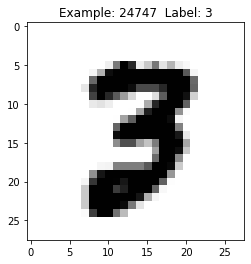

In [3]:
def display_digit(num):
    label = y_train[num]
    image = x_train[num]
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

display_digit(ran.randint(0, x_train.shape[0]))

In [4]:
x_train_res = x_train.reshape(60000, 784)

In [5]:
som = SOM(28, 28, x_train_res.shape[1], 200)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [6]:
som.train(x_train_res[:100])

In [7]:
# Fit train data into SOM lattice
mapped = som.map_vects(x_train_res[:100])
mappedarr = np.array(mapped)
x1 = mappedarr[:,0]; y1 = mappedarr[:,1]

index = [np.where(r==list(range(10)))[0] for r in y_train[:100]]
a = index
index = list(map(str, index))
b = index

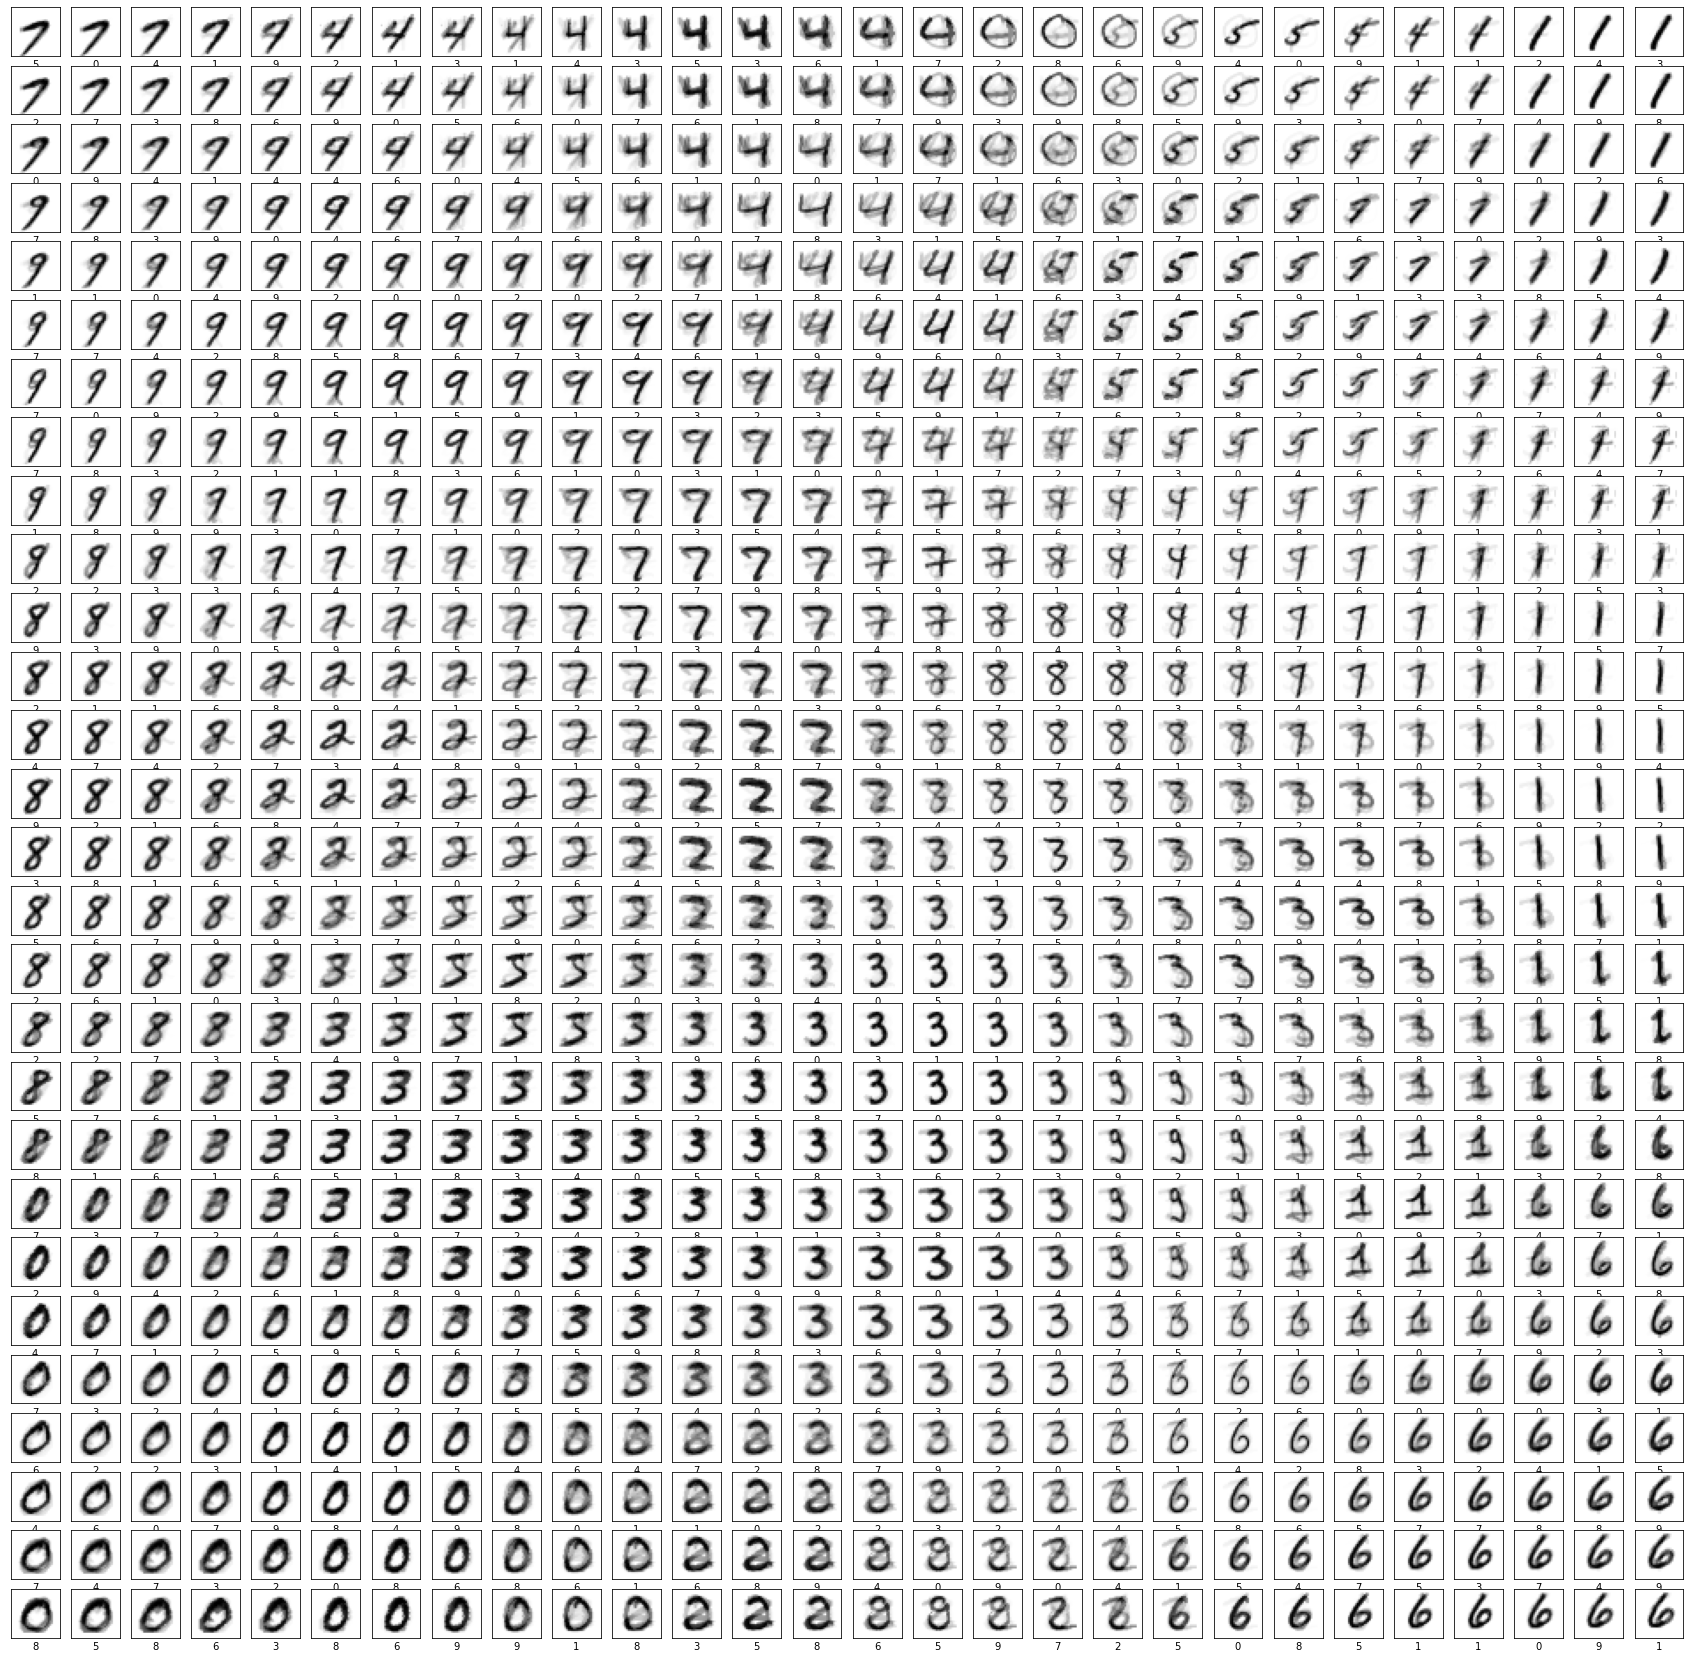

In [8]:
plt.figure(figsize=(30, 30))
for i in range(som.m * som.n):
    plt.subplot(som.m, som.n, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(som.weightages[i].reshape(28, 28), cmap = plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [9]:
# Testing
x_test_res = x_test.reshape(10000, 784)
mappedtest = som.map_vects(x_test_res[:2])
mappedtestarr = np.array(mappedtest)
x2 = mappedtestarr[:,0]
y2 = mappedtestarr[:,1]

index2 = [ np.where(r==list(range(10)))[0] for r in y_test ]
index2 = list(map(str, index2))

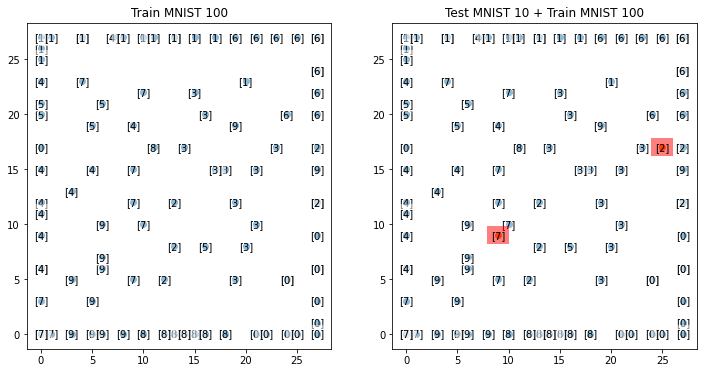

In [10]:
# Plots: 1) Train 2) Test+Train ###

plt.figure(1, figsize=(12,6))
plt.subplot(121)
# Plot 1 for Training only
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.title('Train MNIST 100')


plt.subplot(122)
# Plot 2: Training + Testing
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

plt.scatter(x2,y2)
# Just adding text
for i, m in enumerate(mappedtest):
    plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, lw=0))
plt.title('Test MNIST 10 + Train MNIST 100')

plt.show()

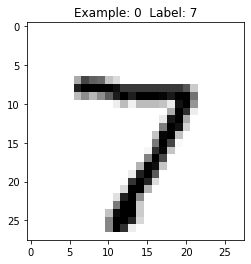

In [11]:
def display_digit(num):
    label = y_test[num]
    image = x_test[num]
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

display_digit(0)

In [12]:
x1

array([16, 24,  3,  0,  6, 12, 15, 19, 13,  0, 19,  0, 21, 27, 13,  0, 13,
       10, 24,  5,  0, 25,  6,  0, 20, 27,  9, 20, 13,  4, 15, 18, 21,  3,
       21,  6, 19, 22,  9, 23, 10, 15, 10,  8, 14,  6, 11,  5, 19, 21, 23,
       27,  9,  7,  6, 13, 27,  5,  0,  0,  0,  0, 27, 27,  5,  0, 27,  8,
        0, 27, 17,  0, 11, 27, 18, 24, 27,  1,  4,  1, 27, 24, 27, 27, 10,
       16, 16,  3, 27,  0, 25,  0,  0, 27, 12, 27,  9, 14, 17,  4])